In [2]:
# All required imports
# Run before using

import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import joblib

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif


In [3]:
# Wczytanie danych
path = "data/LDAP.csv"
dataframe = pd.read_csv(path, low_memory=False)

In [4]:
# Ustawienie wyświetlania wszytskich kolumn i wierszy
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [5]:
# Wyświetlenie ilości w klasach
print (sorted(Counter(dataframe[" Label"]).items()))

[('BENIGN', 5124), ('LDAP', 1905191), ('NetBIOS', 202919)]


In [6]:
# Dzielenie dataframe na klasy

benign = dataframe[dataframe[' Label'] == 'BENIGN']
ldap = dataframe[dataframe[' Label'] == 'LDAP']
netbios = dataframe[dataframe[' Label'] == 'NetBIOS']

# Losowanie próbek z każdej klasy
benign_sampled = benign.sample(n=5000, random_state=42)
ldap_sampled = ldap.sample(n=2500, random_state=42)
netbios_sampled = netbios.sample(n=2500, random_state=42)

# Połączenie danych
df_balanced = pd.concat([benign_sampled, ldap_sampled, netbios_sampled])

# Stworzenie nowych X i Y
X = df_balanced.drop(columns=[' Label'])  # Zakładamy, że kolumna 'label' zawiera etykiety
Y = df_balanced[' Label']

# Sprawdzenie zbalansowania danych w X i Y
print(X.shape)
print(Y.shape)

(10000, 87)
(10000,)


In [7]:
# Ponowne wyświetlenie ilości w klasach
print (sorted(Counter(df_balanced[" Label"]).items()))

[('BENIGN', 5000), ('LDAP', 2500), ('NetBIOS', 2500)]


In [8]:
# Usunięcie pierwszej kolumny 'Unnamed'
dataframe = dataframe.drop(dataframe.columns[0], axis=1)

In [9]:
# Wybieranie cech (ręcznie, na podstawie posiadanej wiedzy)
selected_columns = [' Source Port', ' Destination Port', ' Protocol', ' Fwd Packet Length Max', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', 'Fwd Packets/s', ' Bwd Packets/s',' SYN Flag Count', ' RST Flag Count', ' PSH Flag Count', ' ACK Flag Count', ' Average Packet Size']

# wykorzystanie tylko wcześniej wybranych cech
X = df_balanced[selected_columns]

In [10]:
# Sprawdzenie, czy są brakujące wartości
print(X.isna().sum())  # Liczba brakujących wartości w każdej kolumnie

 Source Port               0
 Destination Port          0
 Protocol                  0
 Fwd Packet Length Max     0
Flow Bytes/s              12
 Flow Packets/s            0
 Flow IAT Mean             0
Fwd Packets/s              0
 Bwd Packets/s             0
 SYN Flag Count            0
 RST Flag Count            0
 PSH Flag Count            0
 ACK Flag Count            0
 Average Packet Size       0
dtype: int64


In [11]:
X = X.fillna(X.mean())  # Wypełnianie brakujących wartości średnią

In [12]:
# Sprawdzenie, czy są brakujące wartości
print(X.isna().sum())  # Liczba brakujących wartości w każdej kolumnie

 Source Port              0
 Destination Port         0
 Protocol                 0
 Fwd Packet Length Max    0
Flow Bytes/s              0
 Flow Packets/s           0
 Flow IAT Mean            0
Fwd Packets/s             0
 Bwd Packets/s            0
 SYN Flag Count           0
 RST Flag Count           0
 PSH Flag Count           0
 ACK Flag Count           0
 Average Packet Size      0
dtype: int64


In [13]:
# Sprawdzenie obecności wartości inf i -inf w danych
print(np.isinf(X).sum())  # Liczba wartości inf w każdej kolumnie

 Source Port                0
 Destination Port           0
 Protocol                   0
 Fwd Packet Length Max      0
Flow Bytes/s              243
 Flow Packets/s           243
 Flow IAT Mean              0
Fwd Packets/s               0
 Bwd Packets/s              0
 SYN Flag Count             0
 RST Flag Count             0
 PSH Flag Count             0
 ACK Flag Count             0
 Average Packet Size        0
dtype: int64


In [14]:
# Zastąpienie wartości inf lub -inf np. średnią danej kolumny
X = X.replace([np.inf, -np.inf], np.nan)  # Zamiana inf na NaN
X = X.fillna(X.mean())  # Wypełnianie NaN średnią

In [15]:
# Sprawdzenie obecności wartości inf i -inf w danych
print(np.isinf(X).sum())  # Liczba wartości inf w każdej kolumnie

 Source Port              0
 Destination Port         0
 Protocol                 0
 Fwd Packet Length Max    0
Flow Bytes/s              0
 Flow Packets/s           0
 Flow IAT Mean            0
Fwd Packets/s             0
 Bwd Packets/s            0
 SYN Flag Count           0
 RST Flag Count           0
 PSH Flag Count           0
 ACK Flag Count           0
 Average Packet Size      0
dtype: int64


In [16]:
# Standaryzacja cech
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [17]:
# Normalizacja cech do zakresu [0, 1]
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

In [18]:
# Podział na dane treningowe i testowe
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

In [19]:
# Tworzenie modelu Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Trenowanie modelu na danych treningowych
model.fit(X_train, Y_train)

# Zapisanie modelu do pliku
joblib.dump(model, 'undersampling_model.pkl')

# Predykcja na danych testowych
Y_pred = model.predict(X_test)

# Ocena dokładności modelu
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy:", accuracy)

# Wyświetlanie raportu klasyfikacji
print(classification_report(Y_test, Y_pred))

Accuracy: 0.9995
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00      1012
        LDAP       1.00      1.00      1.00       492
     NetBIOS       1.00      1.00      1.00       496

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



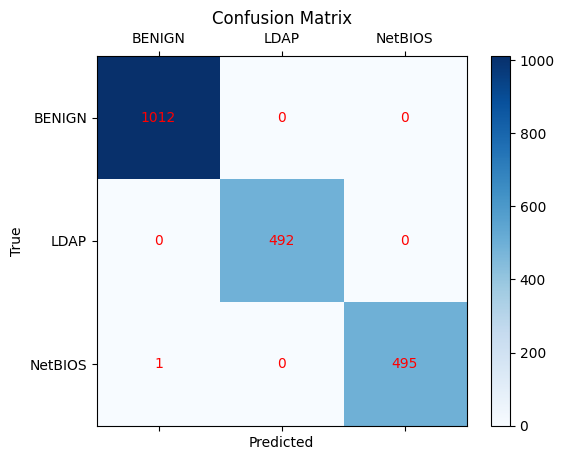

In [20]:
# Obliczenie macierzy pomyłek
cm = confusion_matrix(Y_test, Y_pred)

# Wykres macierzy pomyłek
fig, ax = plt.subplots()
cax = ax.matshow(cm, cmap='Blues')
fig.colorbar(cax)

# Etykiety osi
ax.set_xticks(np.arange(len(model.classes_)))
ax.set_yticks(np.arange(len(model.classes_)))

# Etykiety osi
ax.set_xticklabels(model.classes_)
ax.set_yticklabels(model.classes_)

# Etykiety osi
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Dodanie wartości liczbowych w komórkach
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, val, ha='center', va='center', color='red')

plt.show()


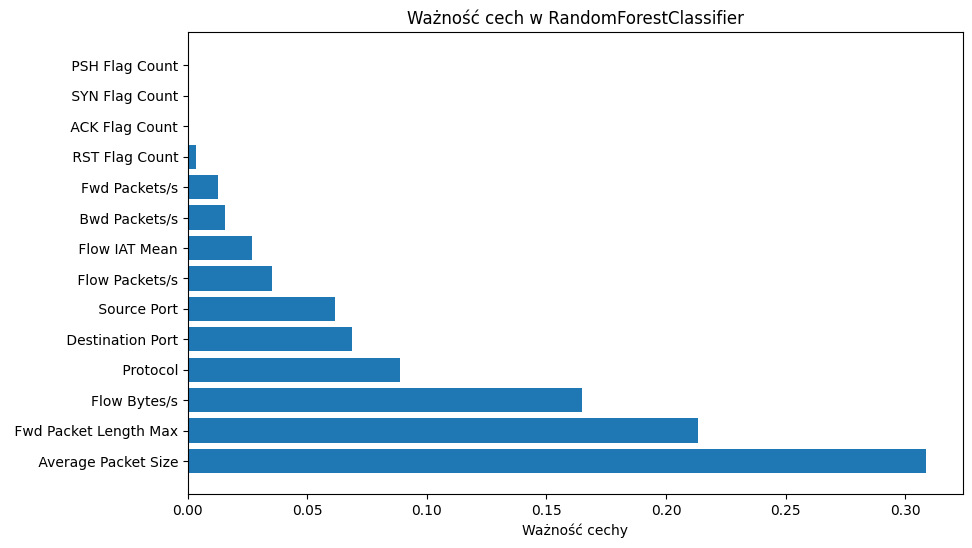

                   Feature  Importance
13     Average Packet Size    0.308744
3    Fwd Packet Length Max    0.213255
4             Flow Bytes/s    0.164776
2                 Protocol    0.088905
1         Destination Port    0.068564
0              Source Port    0.061644
5           Flow Packets/s    0.035024
6            Flow IAT Mean    0.026885
8            Bwd Packets/s    0.015733
7            Fwd Packets/s    0.012540
10          RST Flag Count    0.003398
12          ACK Flag Count    0.000533
9           SYN Flag Count    0.000000
11          PSH Flag Count    0.000000


In [21]:
importances = model.feature_importances_
#Tworzenie DataFrame dla lepszej wizualizacji
features = X.columns  # Jeśli X_train to DataFrame
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

#Sortowanie cech według ważności
importance_df = importance_df.sort_values(by='Importance', ascending=False)

#Wyświetlanie wykresu słupkowego
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Ważność cechy')
plt.title('Ważność cech w RandomForestClassifier')
plt.show()

#Wyświetlenie tabeli z ważnością cech
print(importance_df)